In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 80
mpl.rcParams["figure.dpi"] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [2]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

--2024-03-18 16:38:54--  http://../data/Dolphin
Resolving .. (..)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘..’
--2024-03-18 16:38:54--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.117, 52.222.236.65, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj’

dolphin.obj         100%[===================>] 153.09K   263KB/s    in 0.6s    

2024-03-18 16:38:56 (263 KB/s) - ‘dolphin.obj’ saved [156763/156763]

FINISHED --2024-03-18 16:38:56--
Total wall clock time: 2.2s
Downloaded: 1 files, 153K in 0.6s (263 KB/s)


In [2]:
DATA_DIR = "../Data/Dolphin"
target_obj = os.path.join(DATA_DIR, "dolphin.obj")

In [3]:
verts, faces, aux = load_obj(target_obj)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [4]:
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

In [5]:
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

In [6]:
target_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [7]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

plot_scene(
    {"Dolphin": {"target": target_mesh}},
    axis_args=AxisArgs(
        showgrid=True, zeroline=True, showline=True, backgroundcolor="black"
    ),
)

In [8]:
source_mesh = ico_sphere(4, device)

In [9]:
def plot_pointcloud(mesh, title="", figsize=(5, 5), num_sample_points=5000):
    points = sample_points_from_meshes(mesh, num_samples=num_sample_points)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter3D(x, z, -y)
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

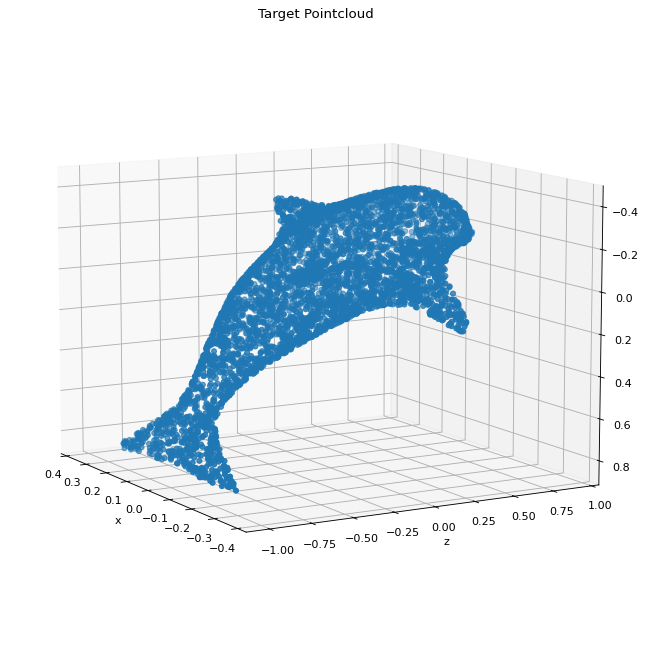

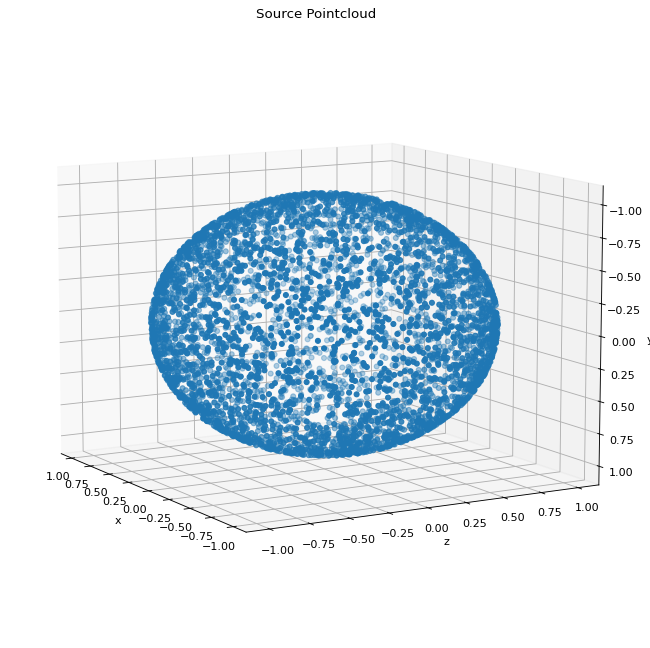

In [10]:
plot_pointcloud(target_mesh, title="Target Pointcloud", figsize=(10, 10))
plot_pointcloud(source_mesh, title="Source Pointcloud", figsize=(10, 10))

In [11]:
deform_verts = torch.full(
    source_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True
)

In [12]:
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [13]:
%matplotlib inline

  0%|          | 0/2000 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/NIE/lib/python3.10/site-packages/pytorch3d/ops/laplacian_matrices.py:49: UserWarning:

torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/torch/csrc/utils/tensor_new.cpp:620.)



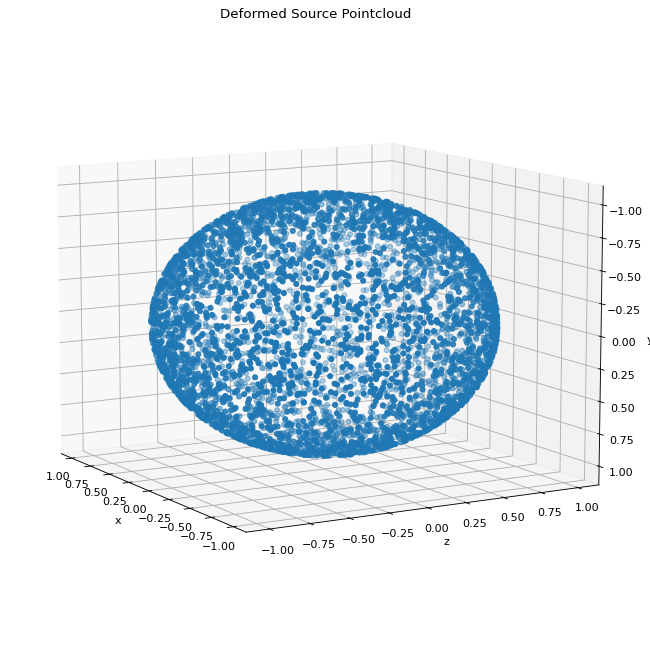

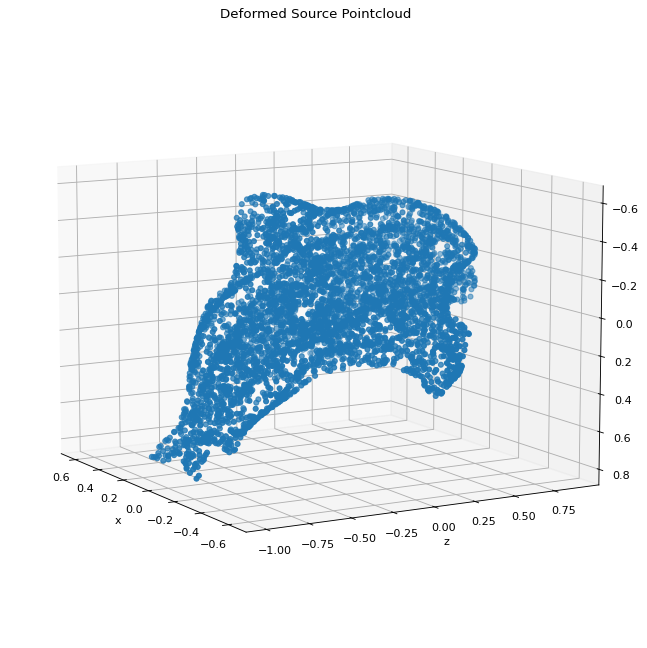

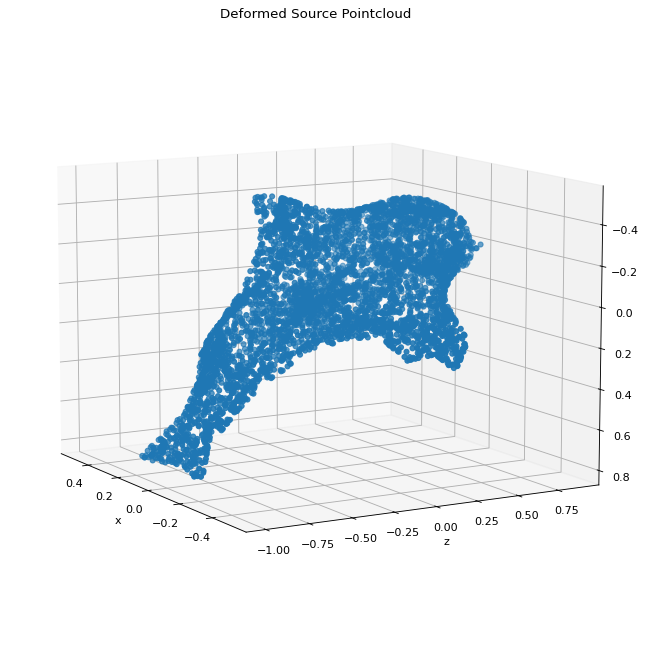

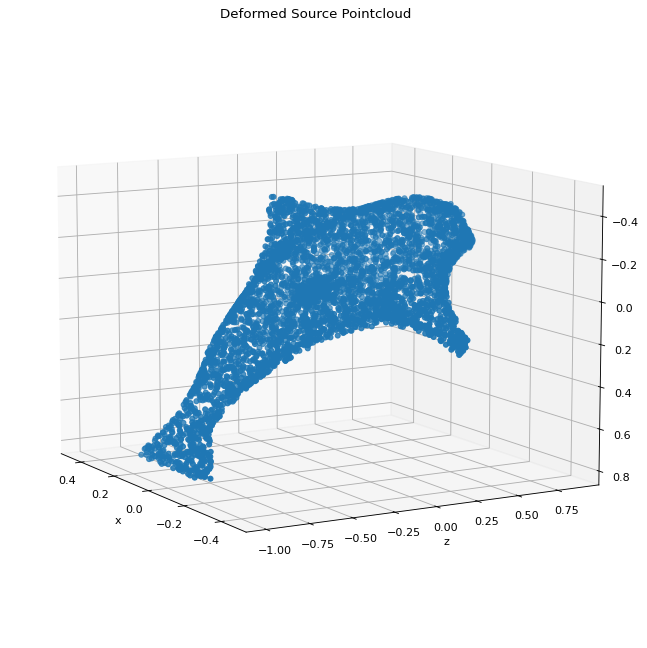

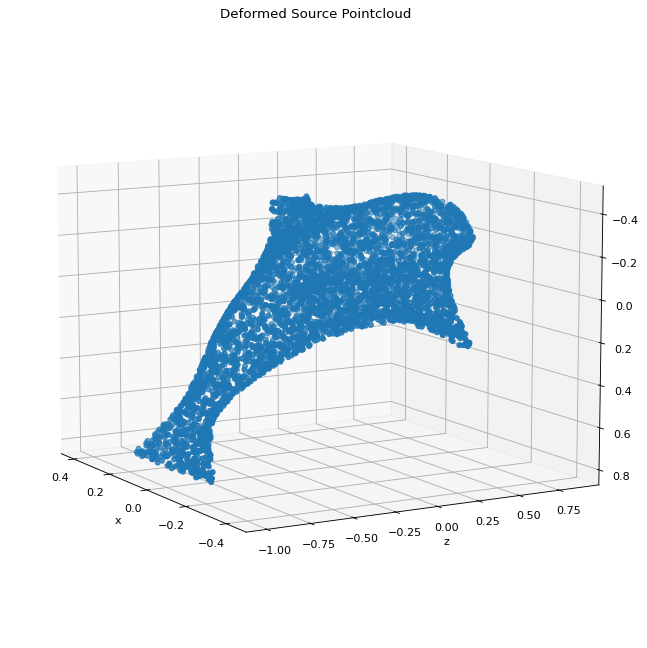

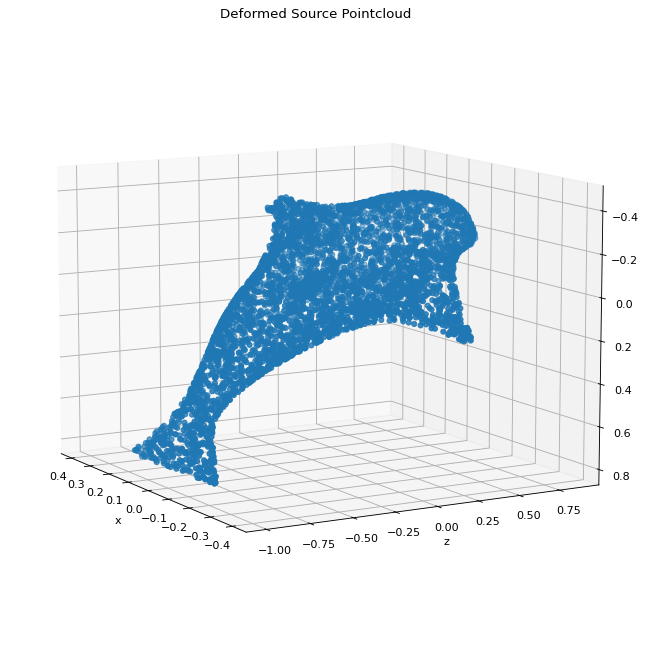

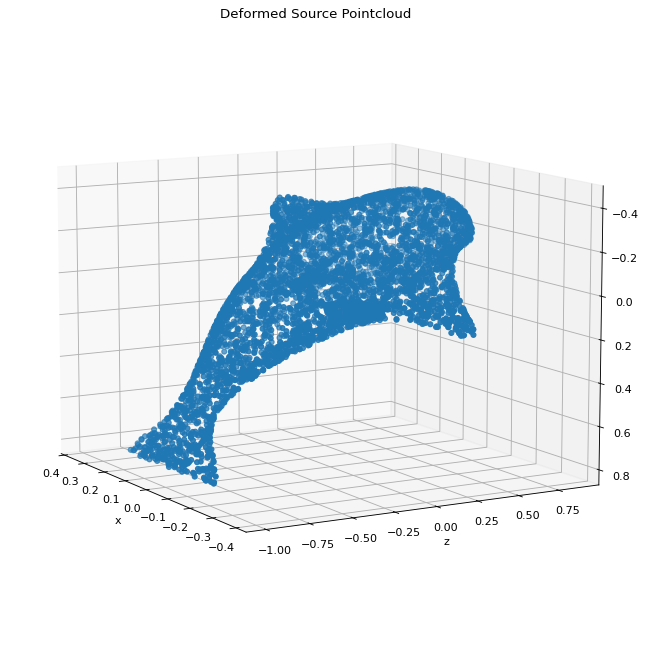

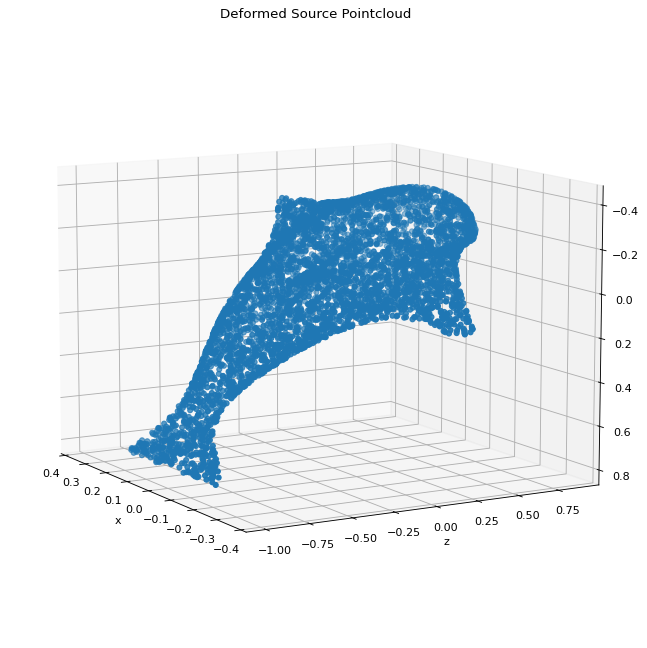

In [14]:
N_ITERS = 2000
w_chamfer = 1.0
w_edge = 1.0
w_normal = 0.01
w_laplacian = 0.1

N_SAMPLE_POINTS = 5000
PLOT_PERIOD = 250
loop = tqdm(range(N_ITERS))

chamfer_dist_losses = []
laplacian_smoothing_losses = []
edge_length_losses = []
normal_consistency_losses = []

for i in loop:
    optimizer.zero_grad()

    new_source_mesh = source_mesh.offset_verts(deform_verts)
    sampled_target = sample_points_from_meshes(target_mesh, N_SAMPLE_POINTS)
    sampled_source = sample_points_from_meshes(new_source_mesh, N_SAMPLE_POINTS)

    chamfer_dist_loss, _ = chamfer_distance(sampled_target, sampled_source)
    edge_length_loss = mesh_edge_loss(new_source_mesh)
    normal_consistency_loss = mesh_normal_consistency(new_source_mesh)
    laplacian_smoothing_loss = mesh_laplacian_smoothing(
        new_source_mesh, method="uniform"
    )

    loss = (
        w_chamfer * chamfer_dist_loss
        + w_edge * edge_length_loss
        + w_normal * normal_consistency_loss
        + w_laplacian * laplacian_smoothing_loss
    )

    loop.set_description("total_loss = %.6f" % loss.item())

    chamfer_dist_losses.append(chamfer_dist_loss.item())
    laplacian_smoothing_losses.append(laplacian_smoothing_loss.item())
    edge_length_losses.append(edge_length_loss.item())
    normal_consistency_losses.append(normal_consistency_loss.item())

    if i % PLOT_PERIOD == 0:
        plot_pointcloud(
            new_source_mesh, title="Deformed Source Pointcloud", figsize=(10, 10)
        )

    loss.backward()
    optimizer.step()

Text(0.5, 1.0, 'Loss vs iterations')

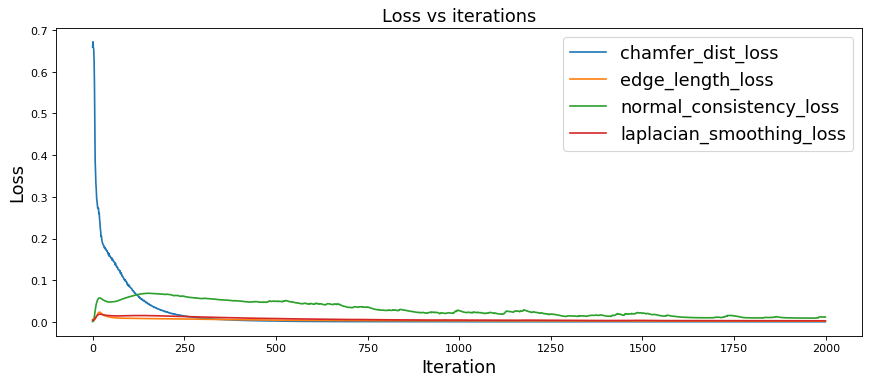

In [17]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_dist_losses, label="chamfer_dist_loss")
ax.plot(edge_length_losses, label="edge_length_loss")
ax.plot(normal_consistency_losses, label="normal_consistency_loss")
ax.plot(laplacian_smoothing_losses, label="laplacian_smoothing_loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")